# 1D floating, elastic beam (mixed formulation)

## Problem description

Consider a floating shelf of uniform thickness $H$, with unknown deflection $\eta = \eta(x)$ and bending moment $M = M(x)$. The bending moment at the terminus, $M_t$, is forced by flotation conditions at that boundary. The shelf is loaded everywhere with a buoyancy force of $f = -\rho_wg\eta$. Define $\lambda := \frac{E}{12(1 - \mu^2)}$, where $E$ is Young's Modulus and $\mu$ is Poisson's Ratio. Then the governing equation and constitutive relation on the shelf are:

$$
-M'' = -\rho_wg\eta
$$

$$
M = -H^3\lambda\eta''.
$$ 

Let $n$ and $m$ be arbitrary functions in $x$. From the product rule and the Fundamental Theorem of Calculus, it can be derived that the corresponding weak forms for these equations are:

$$
\int_xm'M' - [mM']_{x_0}^{x_1} = -\int_xm\rho_wg\eta
$$

$$
\int_xnM = \int_x(H^3\lambda n)'\eta' - [H^3\lambda n\eta']_{x_0}^{x_1}
$$

## Boundary conditions

We need four boundary conditions to solve this problem:

- On the left boundary, assume that $\eta_0 = M_0 = 0$ (i.e., the grounding line acts as a hinge, permitting neither deflection nor bending). These two boundary conditions can be enforced directly via firedrake's ```DirichletBC```.

- On the right boundary, $M'_1 = 0$ (no shear force acts on the terminal cliff). This can be enforced using the penalty method.

- On the right boundary, $M_1 = -\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1) - \frac{1}{2}\rho_igH^2\eta_1(\varrho - 1)$, where $\varrho$ is the ratio of ice density to water density (this is a corrected version of Eq. 8 in [Reeh, 2003](https://www.cambridge.org/core/journals/annals-of-glaciology/article/tidal-bending-of-glaciers-a-linear-viscoelastic-approach/0DA11FFD20C74161779C1D11620A94A8#ref18), or Eq. 22 from [Reeh, 1968](https://www.cambridge.org/core/journals/journal-of-glaciology/article/on-the-calving-of-ice-from-floating-glaciers-and-ice-shelves/0E16F201FB4FF676826078C7C5F487DE)). Note that, if we assume the terminus remains exactly at flotation, so that $\eta_1 = 0$, this is equivalent to Eq. 10 in [Lipovsky, 2020](https://tc.copernicus.org/articles/14/1673/2020/). This final boundary condition is enforced by adding the boundary term:

$$\int_\Gamma mM = -\int_\Gamma\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)m - \int_\Gamma\frac{1}{2}\rho_igH^2\eta(\varrho - 1)m$$

## Finite element setup

Consequently, define

$$ 
a((\eta, M), (n, m)) := \int_xm'M' + \int_xnM - \int_x(H^3\lambda n)'\eta' + \int_xm\rho_wg\eta + \int_\Gamma mM + \int_\Gamma\frac{1}{2}\rho_igH^2\eta(\varrho - 1)m
$$

$$
L(n, m) := -\int_\Gamma\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1)m
$$

The goal is now to find $(\eta, M)$ such that $a = L$ for all $(m, n)$. 
## Imports

In [1]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

## Material parameters

In [2]:
H = 100 #shelf thickness in meters
ρ_i = 917 #density of ice (kg/m^3)
ρ_w = 1024 #density of seawater
ϱ = ρ_i/ρ_w #density ratio
g = 9.81 #gravitational constant (N/kg)

E = 1e4 #Young's Modulus (Pa)
μ = 1/3 #Poisson's Ratio
λ = E/(12*(1 - μ**2)) #1D equivalent of Lame parameter
α = 1e10 #large number for penalty method

## Meshing 

Set the length of the shelf to $L = \frac{2n\pi}{\sqrt[4]{\frac{3(1 - \mu^2)}{EH^3}\rho_wg}}$ for some positive integer $n$ (this will give the analytic solution, outlined later, a nicer form).

In [3]:
nx = 500 #number of nodes
D = sqrt(sqrt((3*ρ_w*g*(1 - μ**2)/(E*H**3)))) #for determining the length scale; see above
n_length = 1 #see above
Lx = 2*n_length*pi/D #length of mesh in meters
print(f'L = {Lx:.2f} meters')
mesh = IntervalMesh(nx, Lx)

Q1 = FunctionSpace(mesh, 'CG', 3) #this will be η's function space
Q2 = FunctionSpace(mesh, 'CG', 3) #and M's function space
Q = Q1*Q2 #mixed function space for (η, M)

η, M = TrialFunctions(Q) #trial functions for the deflection η, moment M_xx
n, m = TestFunctions(Q)
q = Function(Q) #q = (η solution, M solution)

x = SpatialCoordinate(mesh)
X = np.arange(0, Lx, 1) #for plotting later

L = 155.31 meters


## Solve with firedrake

Set up using the values of $a$ and $L$ described above.

In [4]:
a = grad(m)[0]*grad(M)[0]*dx + n*M*dx - grad(H**3*λ*n)[0]*grad(η)[0]*dx + ρ_w*g*η*m*dx + M*m*ds + 1/2*ρ_i*g*H**2*η*(ϱ - 1)*m*ds
L = -1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1)*m*ds

bc_η = DirichletBC(Q.sub(0), 0, 1) #η = 0 on left boundary
bc_M = DirichletBC(Q.sub(1), 0, 1) #M = 0 on left boundary
a += 1/2*α**2*n*grad(M)[0]*ds(2) #also enforce M' = 0 at terminus

solve(a == L, q, bcs = [bc_η, bc_M])

## Plot, and compare with the analytic solution

The analytic solutions for $\eta$ and $M$, given a known terminus deflection $\eta_1$, are

$$\eta = \frac{\eta_1}{e^{DL} - e^{-DL}}\left(e^{Dx}\sin(Dx) + e^{-Dx}\sin(Dx) + e^{Dx}\cos(Dx) - e^{-Dx}\cos(Dx)\right),$$

$$M = \frac{2D^2H^3\lambda\eta_1}{e^{DL} - e^{-DL}}\left(e^{Dx}\sin(Dx) + e^{-Dx}\sin(Dx) - e^{Dx}\cos(Dx) + e^{-Dx}\cos(Dx)\right),$$

with $D := \sqrt[4]{\frac{3(1 - \mu^2)}{EH^3}\rho_wg}$. Therefore, we can compare our numerical solution with the corresponding analytic solution by setting $\eta_1$ equal to firedrake's output value:

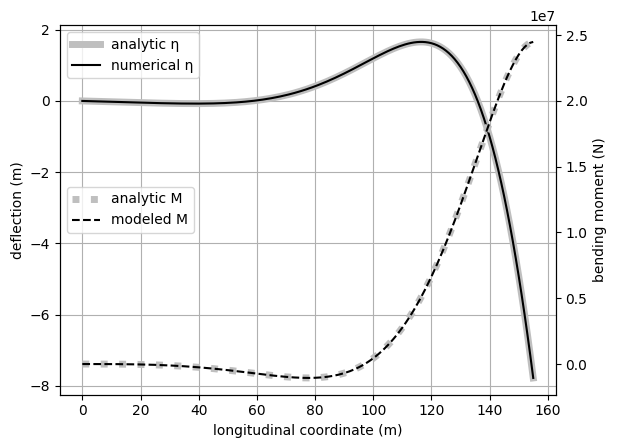

In [5]:
η_1 = Function(Q1).project(q[0]).at(Lx, tolerance = 1e-10) #take our modeled terminus deflection...
C_1 = η_1/(np.exp(D*Lx) - np.exp(-D*Lx)) #...and input its value into the analytic general form
C_2 = 2*D**2*H**3*λ*C_1
analytic_η_profile = C_1*(np.exp(D*X)*np.sin(D*X) + np.exp(-D*X)*np.sin(D*X) + np.exp(D*X)*np.cos(D*X) - np.exp(-D*X)*np.cos(D*X))
analytic_M_profile = C_2*(np.exp(D*X)*np.sin(D*X) + np.exp(-D*X)*np.sin(D*X) - np.exp(D*X)*np.cos(D*X) + np.exp(-D*X)*np.cos(D*X))

modeled_η_profile = Function(Q1).project(q[0]).at(X, tolerance = 1e-10)
modeled_M_profile = Function(Q2).project(q[1]).at(X, tolerance = 1e-10)

plt.figure()
plt.plot(analytic_η_profile, color = '0.75', linewidth = 5, label = 'analytic η')
plt.plot(modeled_η_profile, color = 'k', linestyle = 'solid', label = 'numerical η')
plt.legend(loc = 'upper left')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('deflection (m)')
plt.grid()
plt.twinx()
plt.plot(analytic_M_profile, color = '0.75', linewidth = 5, linestyle = 'dotted', label = 'analytic M')
plt.plot(modeled_M_profile, color = 'k', linestyle = 'dashed', label  = 'modeled M')
plt.ylabel('bending moment (N)')
plt.legend(loc = 'center left')
plt.show()

## Test that boundary conditions and governing equations are preserved

In general, we won't have analytic solutions to compare with. We can still check that our solution is correct by determining whether all our initial constraints are preserved. For example, we can check that the bending moment at the terminus relates to the terminal deflection via 

$$M_1 = -\frac{1}{12}\rho_igH^3(2\varrho^2 - 3\varrho + 1) - \frac{1}{2}\rho_igH^2\eta_1(\varrho - 1)$$

In [6]:
desired_M1 = -1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1) - 1/2*ρ_i*g*H**2*η_1*(ϱ - 1) #"correct" value of M at the boundary
modeled_M1 = Function(Q1).project(q[1]).at(Lx, tolerance = 1e-10) #modeled value of M at the boundary

print(f'desired value: {desired_M1}; modeled value: {modeled_M1}') 
print(f'difference: {desired_M1 - modeled_M1}; relative difference: {(desired_M1 - modeled_M1)/desired_M1}')

desired value: 24476255.449450076; modeled value: 24476255.514946945
difference: -0.06549686938524246; relative difference: -2.6759350310144776e-09


Similarly, we can verify that our governing and constitutive relations are satisfied by the solution. We expect to have: 

$$
-M'' = -\rho_wg\eta
$$

$$
M = -H^3\lambda\eta''.
$$ 

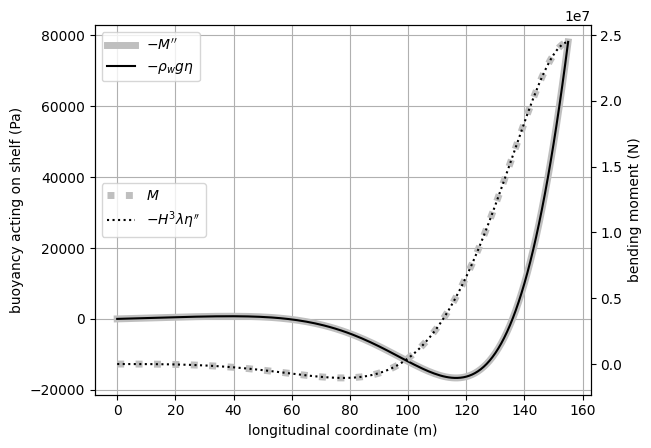

In [7]:
governing_LHS = Function(Q1).project(-grad(grad(q[1]))[0, 0]).at(X, tolerance = 1e-10) #-M''
governing_RHS = Function(Q1).project(-ρ_w*g*q[0]).at(X, tolerance = 1e-10) #-ρ_wgη

constitutive_LHS = Function(Q2).project(q[1]).at(X, tolerance = 1e-10) #M
constitutive_RHS = Function(Q2).project(-H**3*λ*grad(grad(q[0]))[0, 0]).at(X, tolerance = 1e-10) #-H^3λη''

plt.figure()
plt.plot(governing_LHS, color = '0.75', linewidth = 5, label = '$-M\'\'$')
plt.plot(governing_RHS, color = 'k', label = '$-ρ_wgη$')
plt.grid()
plt.ylabel('buoyancy acting on shelf (Pa)')
plt.xlabel('longitudinal coordinate (m)')
plt.legend(loc = 'upper left')
plt.twinx()
plt.plot(constitutive_LHS, color = '0.75', linewidth = 5, linestyle = 'dotted', label = '$M$')
plt.plot(constitutive_RHS, color = 'k', linestyle = 'dotted', label = '$-H^3λη\'\'$')
plt.ylabel('bending moment (N)')
plt.legend(loc = 'center left')
plt.show()

## Epilogue: incorporating flow stresses

If we consider the depth-averaged stress state due to shallow shelf flow, $\overline{\sigma}$, the governing equation can be rewritten as

$$-M'' = -\rho_wg\eta + \overline{\sigma}\eta'',$$

in which case the weak form now includes two additional terms, with

$$\int_xm'M' - [mM']_{x_0}^{x_1} = -\int_xm\rho_wg\eta - \int_x(\overline{\sigma}m)'\eta' + [\overline{\sigma}m\eta']_{x_0}^{x_1}$$

Furthermore, $\overline{\sigma} = \overline{\tau} - \overline{P}$, with $\overline{\tau}$ the depth-averaged deviatoric stress and $\overline{P}$ the depth-averaged pressure. In a 1D hydrostatic setting, $\overline{P} = \frac{1}{2}\rho_igH - \overline{\tau}$. Assuming the shelf to be in uniaxial extension, we also know that $\overline{\tau} \approx \frac{1}{4}\rho_ig(1 - \varrho)H.$ It follows that

$$\overline{\sigma} \approx -\frac{1}{2}\rho_igH\varrho.$$

Therefore, we redefine $a$ so that 

$$
a((\eta, M), (n, m)) := \int_xm'M' + \int_xnM - \int_x(H^3\lambda n)'\eta' + \int_xm\rho_wg\eta + \int_\Gamma mM + \int_\Gamma\frac{1}{2}\rho_igH^2\eta(\varrho - 1)m + \int_x(\overline{\sigma}m)'\eta'
$$

However, notice that Young's Modulus has to be extremely low for the inclusion of flow stresses to make a difference here. This is because, with $H$ on the order of 100 meters, the constitutive relation requires $M = -H^3\frac{E}{12(1 - \mu^2)}\eta'' \approx -10^5E\eta''$, whereas our additional flow term is only $\overline{\sigma}\eta'' \approx - 10^5\eta''$. With typical values of $E$ on the order of $10^9$ Pa, the flow term is dwarfed. **This term may only be important when damage is incorporated.** 

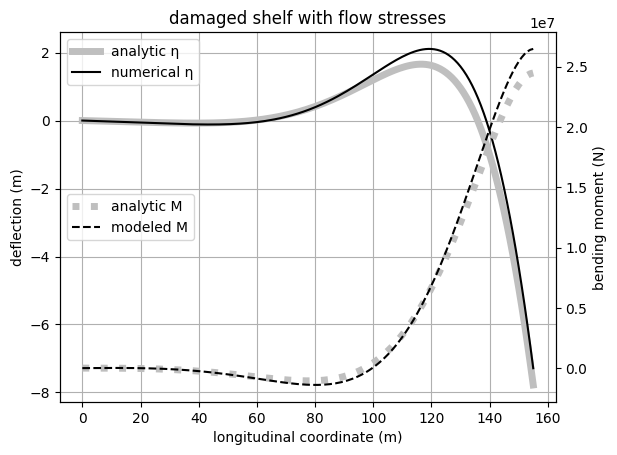

In [8]:
σ = -1/2*ρ_i*g*H*ϱ

a = grad(m)[0]*grad(M)[0]*dx + n*M*dx - grad(H**3*λ*n)[0]*grad(η)[0]*dx + ρ_w*g*η*m*dx + M*m*ds + 1/2*ρ_i*g*H**2*η*(ϱ - 1)*m*ds
a += grad(σ*m)[0]*grad(η)[0]*dx #add the flow stress term
L = -1/12*ρ_i*g*H**3*(2*ϱ**2 - 3*ϱ + 1)*m*ds

bc_η = DirichletBC(Q.sub(0), 0, 1) #η = 0 on left boundary
bc_M = DirichletBC(Q.sub(1), 0, 1) #M = 0 on left boundary
a += 1/2*α**2*n*grad(M)[0]*ds(2) #also enforce M' = 0 at terminus

solve(a == L, q, bcs = [bc_η, bc_M])

new_η_solution = Function(Q1).project(q[0]).at(X, tolerance = 1e-10)
new_M_solution = Function(Q2).project(q[1]).at(X, tolerance = 1e-10)

plt.figure()
plt.title('damaged shelf with flow stresses')
plt.plot(analytic_η_profile, color = '0.75', linewidth = 5, label = 'analytic η')
plt.plot(new_η_solution, color = 'k', linestyle = 'solid', label = 'numerical η')
plt.legend(loc = 'upper left')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('deflection (m)')
plt.grid()
plt.twinx()
plt.plot(analytic_M_profile, color = '0.75', linewidth = 5, linestyle = 'dotted', label = 'analytic M')
plt.plot(new_M_solution, color = 'k', linestyle = 'dashed', label  = 'modeled M')
plt.ylabel('bending moment (N)')
plt.legend(loc = 'center left')
plt.show()